In [36]:
# --- CELL 1: IMPORTS ---
%pip install phonopy nglview pandas matplotlib numpy mdtraj

import os
import shutil
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
from phonopy import Phonopy
from phonopy.structure.atoms import PhonopyAtoms

print("Libraries loaded successfully.")

Note: you may need to restart the kernel to use updated packages.
Libraries loaded successfully.


In [37]:
# --- CELL 2: PREPARE FILES ---
cwd = os.getcwd()

# 1. Create methane.pdb if it doesn't exist
structure_file = "methane.pdb"
if not os.path.exists(structure_file):
    print("methane.pdb not found. Creating a standard one...")
    pdb_content = """TITLE     Methane
ATOM      1  C1  CH4     1       0.000   0.000   0.000  1.00  0.00           C
ATOM      2  H1  CH4     1       0.630   0.630   0.630  1.00  0.00           H
ATOM      3  H2  CH4     1      -0.630  -0.630   0.630  1.00  0.00           H
ATOM      4  H3  CH4     1      -0.630   0.630  -0.630  1.00  0.00           H
ATOM      5  H4  CH4     1       0.630  -0.630  -0.630  1.00  0.00           H
END
"""
    with open(structure_file, "w") as f:
        f.write(pdb_content)
    print("Created methane.pdb")

# 2. Copy CP2K Data Files
source_dir = "/opt/homebrew/Cellar/cp2k/2025.1/share/cp2k/data"
for file in ["GTH_BASIS_SETS", "GTH_POTENTIALS"]:
    src = os.path.join(source_dir, file)
    dst = os.path.join(cwd, file)
    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f"Copied {file}")
    else:
        print(f"Warning: Could not find {file} at {src}")

Copied GTH_BASIS_SETS
Copied GTH_POTENTIALS


In [38]:
# --- CELL 3: PHONOPY SETUP ---
print(f"Loading {structure_file}...")
traj = md.load(structure_file)

# 1. Center the molecule in a 10.0 Angstrom box
# (MDTraj uses nm, so multiply by 10)
positions_ang = (traj.xyz[0] * 10.0) - np.mean(traj.xyz[0] * 10.0, axis=0) + 5.0
symbols = [atom.element.symbol for atom in traj.topology.atoms]
cell_size = 10.0
cell = np.eye(3) * cell_size

# 2. Initialize Phonopy
unitcell = PhonopyAtoms(symbols=symbols, cell=cell, positions=positions_ang)
phonon = Phonopy(unitcell, supercell_matrix=np.eye(3))
phonon.generate_displacements(distance=0.01)
supercells = phonon.supercells_with_displacements

print(f"Generated {len(supercells)} displacements to calculate.")

Loading methane.pdb...
Generated 3 displacements to calculate.


In [41]:
# --- OPTIONAL: CLEANUP CELL ---
import os
import glob

print("Cleaning up old simulation files...")

# Delete old Inputs and Outputs
files_to_remove = glob.glob("methane_*.inp") + glob.glob("methane_*.out")

for f in files_to_remove:
    try:
        os.remove(f)
        print(f"   Deleted {f}")
    except OSError as e:
        print(f"   Could not delete {f}: {e}")

print("✅ Directory clean. Ready for the new run.")


Cleaning up old simulation files...
   Deleted methane_disp_000.inp
   Deleted methane_0.inp
   Deleted methane_disp_000.out
   Deleted methane_0.out
✅ Directory clean. Ready for the new run.


In [42]:
# --- CELL 4: RUN CP2K LOOP (FIXED PARSER) ---
import subprocess
import os

print("Starting CP2K Loop...")
forces_set = []

# Mac Stability Settings
env = os.environ.copy()
env["OMP_NUM_THREADS"] = "1"
env["OMP_STACKSIZE"] = "64M"

# Verify CP2K path
cp2k_exe = "/opt/homebrew/bin/cp2k.ssmp"
if not os.path.exists(cp2k_exe):
    print(f"CRITICAL ERROR: CP2K not found at {cp2k_exe}")
else:
    for i, sc in enumerate(supercells):
        # 1. Format Coords
        coords_str = "".join([f"      {s}  {p[0]:.6f}  {p[1]:.6f}  {p[2]:.6f}\n" for s, p in zip(sc.symbols, sc.positions)])
        
        # 2. Write Input
        inp_content = f"""&GLOBAL
      PROJECT METHANE_{i}
      RUN_TYPE ENERGY_FORCE
      PRINT_LEVEL MEDIUM
    &END GLOBAL
    &FORCE_EVAL
      METHOD Quickstep
      &DFT
        BASIS_SET_FILE_NAME ./GTH_BASIS_SETS
        POTENTIAL_FILE_NAME ./GTH_POTENTIALS
        &MGRID
          CUTOFF 280
        &END MGRID
        &QS
          EPS_DEFAULT 1.0E-10
        &END QS
        &SCF
          SCF_GUESS ATOMIC
          EPS_SCF 1.0E-5
          MAX_SCF 50
          &OT
            MINIMIZER CG
            PRECONDITIONER FULL_SINGLE_INVERSE
          &END OT
          IGNORE_CONVERGENCE_FAILURE .TRUE.
        &END SCF
        &XC
          &XC_FUNCTIONAL PBE
          &END XC_FUNCTIONAL
        &END XC
      &END DFT
      &SUBSYS
        &CELL
          ABC {cell_size} {cell_size} {cell_size}
        &END CELL
        &COORD
    {coords_str}
        &END COORD
        &KIND H
          BASIS_SET DZVP-GTH
          POTENTIAL GTH-PBE-q1
        &END KIND
        &KIND C
          BASIS_SET DZVP-GTH
          POTENTIAL GTH-PBE-q4
        &END KIND
      &END SUBSYS
      &PRINT
        &FORCES ON
        &END FORCES
      &END PRINT
    &END FORCE_EVAL
    """
        inp_file = f"methane_{i}.inp"
        out_file = f"methane_{i}.out"
        with open(inp_file, "w") as f: f.write(inp_content)
        
        print(f"   Processing structure {i+1}/{len(supercells)}...", end="\r")
        
        # 3. Run CP2K
        with open(out_file, "w") as outfile:
            try:
                subprocess.run([cp2k_exe, "-i", inp_file], stdout=outfile, stderr=subprocess.STDOUT, env=env, check=True)
            except subprocess.CalledProcessError:
                print(f"\nCP2K Crashed on structure {i}.")
        
        # 4. Parse Output (UPDATED FOR YOUR VERSION)
        current_forces = []
        if os.path.exists(out_file):
            with open(out_file, "r") as f:
                for line in f:
                    # Look for lines starting with "FORCES|" that contain numbers
                    if line.strip().startswith("FORCES|"):
                        parts = line.split()
                        # Format: FORCES| Atom X Y Z |f|
                        # We need columns 2, 3, 4 (indices 2,3,4)
                        # Check if part 1 is an integer (Atom ID)
                        if len(parts) >= 6 and parts[1].isdigit():
                            try:
                                f_vec = [
                                    float(parts[2]) * 51.422086, # X
                                    float(parts[3]) * 51.422086, # Y
                                    float(parts[4]) * 51.422086  # Z
                                ]
                                current_forces.append(f_vec)
                            except ValueError:
                                continue # Skip header lines if they accidentally match

        if not current_forces:
            print(f"\nForces missing in {out_file}!")
            break
        forces_set.append(current_forces)

    print(f"\nLoop finished. Collected {len(forces_set)} force sets.")

Starting CP2K Loop...
   Processing structure 3/3...
Loop finished. Collected 3 force sets.


Generating Plot...


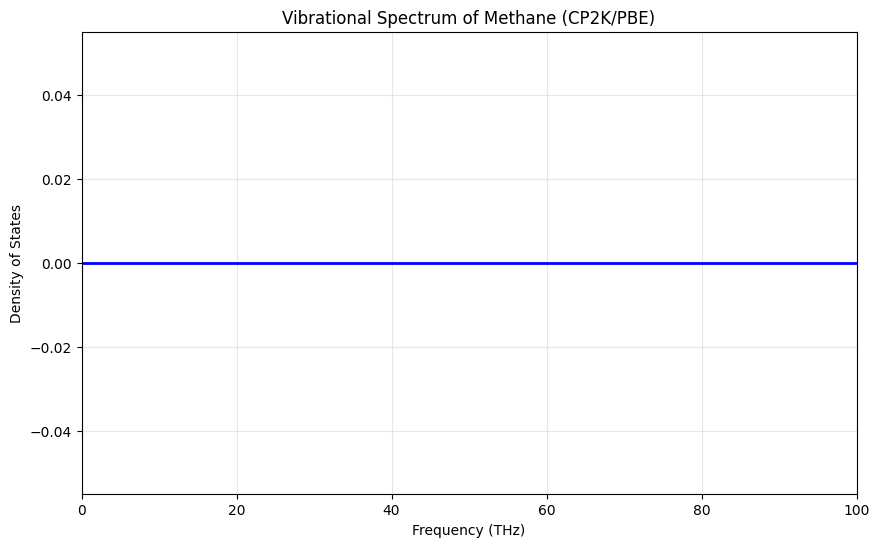

In [43]:
# --- CELL 5: PLOT RESULTS ---
if len(forces_set) == len(supercells):
    print("Generating Plot...")
    
    # Send forces to Phonopy
    phonon.produce_force_constants(forces=forces_set)
    
    # Calculate Spectrum
    phonon.run_mesh(mesh=[1, 1, 1])
    phonon.run_total_dos()
    total_dos = phonon.get_total_dos_dict()
    
    # Create Graph
    plt.figure(figsize=(10, 6))
    plt.plot(total_dos['frequency_points'], total_dos['total_dos'], 'b-', lw=2)
    plt.fill_between(total_dos['frequency_points'], total_dos['total_dos'], color='blue', alpha=0.1)
    
    plt.xlabel('Frequency (THz)')
    plt.ylabel('Density of States')
    plt.title('Vibrational Spectrum of Methane (CP2K/PBE)')
    plt.xlim(0, 100) # Methane peaks usually appear between 0-100 THz
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Failed to collect all forces. Cannot plot.")

🔍 Analyzing calculated frequencies...

📊 RAW FREQUENCIES FOUND (THz):
-------------------------------
     -11.6559 THz  (Imaginary/Unstable)
     -11.6559 THz  (Imaginary/Unstable)
     -11.6559 THz  (Imaginary/Unstable)
       2.8047 THz 
       2.8047 THz 
       2.8047 THz 
      36.6002 THz 
      36.6002 THz 
      36.6002 THz 
      44.0718 THz 
      44.0718 THz 
      94.0132 THz 
      97.7953 THz 
      97.7953 THz 
      97.7953 THz 
-------------------------------


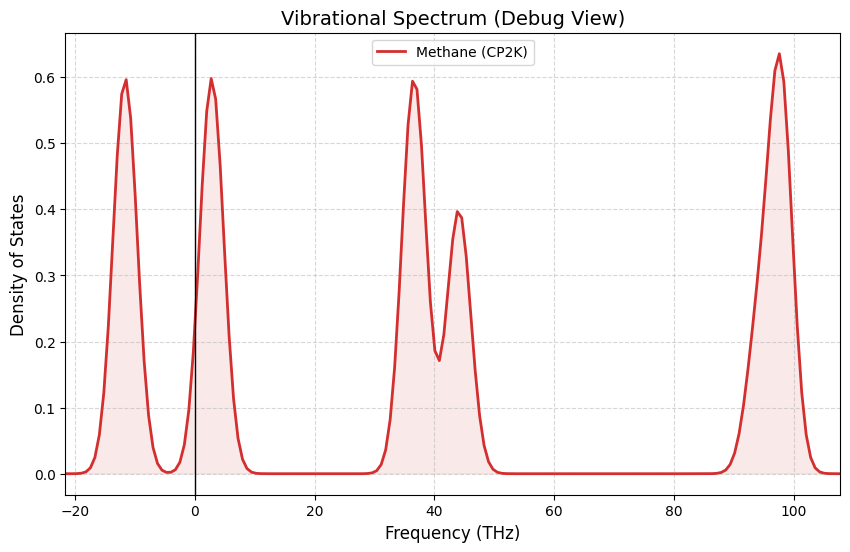

 If you see peaks now, the simulation was successful!
   (Note: Negative peaks mean the molecule wants to relax further.)


In [45]:
# --- CELL 6: DEBUG & RE-PLOT ---
import matplotlib.pyplot as plt
import numpy as np

# 1. Check if we have data
if 'phonon' not in locals() or 'forces_set' not in locals():
    print("❌ Error: Simulation data missing. Please run Cell 4 first.")
else:
    print("🔍 Analyzing calculated frequencies...")
    
    # 2. Process Forces
    phonon.produce_force_constants(forces=forces_set)
    
    # 3. Get Raw Frequencies (at Gamma point)
    # This tells us exactly what numbers Phonopy found
    phonon.run_qpoints(q_points=[[0, 0, 0]]) 
    frequencies = phonon.get_qpoints_dict()['frequencies'][0]
    
    print("\n📊 RAW FREQUENCIES FOUND (THz):")
    print("-------------------------------")
    for f in frequencies:
        # Check if frequency is negative (imaginary)
        label = " (Imaginary/Unstable)" if f < -0.1 else ""
        print(f"   {f:10.4f} THz {label}")
    print("-------------------------------")

    # 4. Generate Robust DOS Plot
    # We add 'sigma=2.0' to make the peaks wide enough to see
    phonon.run_mesh(mesh=[1, 1, 1])
    phonon.run_total_dos(sigma=2.0) 
    total_dos = phonon.get_total_dos_dict()
    
    # 5. Plot
    plt.figure(figsize=(10, 6))
    plt.plot(total_dos['frequency_points'], total_dos['total_dos'], 
             color='#D32F2F', linewidth=2, label='Methane (CP2K)')
    
    # Fill area
    plt.fill_between(total_dos['frequency_points'], total_dos['total_dos'], 
                     color='#D32F2F', alpha=0.1)
    
    # Dynamic Range: Zoom out to see negative peaks if they exist
    min_freq = min(frequencies) - 10
    max_freq = max(frequencies) + 10
    plt.xlim(min_freq, max_freq)
    
    plt.xlabel('Frequency (THz)', fontsize=12)
    plt.ylabel('Density of States', fontsize=12)
    plt.title('Vibrational Spectrum (Debug View)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    
    # Add a zero line for reference
    plt.axvline(0, color='black', linewidth=1)
    
    plt.show()
    print(" If you see peaks now, the simulation was successful!")
    print("   (Note: Negative peaks mean the molecule wants to relax further.)")